In [27]:
using LinearAlgebra
using Plots

# Basic parameters
vs = 1000    # Wave velocity [m/s] 
f = 1.0        # Central frequency of the source (in Hz)
λ = vs / f      # Wavelength

# Adjust the spatial and temporal parameters to satisfy the CFL condition
ep = 0.3     # Stability limit (0.3 is a good value for the explicit scheme)
dx = 0.1 * λ  # Spatial step size (about 1/10 of a wavelength)
dt = ep * dx / vs    # Time step size based on the CFL condition

t_max = 10.0    # Maximum simulation time (in seconds)
x_max = 10000.0    # Maximum spatial coordinate (in meters) nanti jadi 10 km

println("Spatial step size: $dx")
println("Time step size: $dt")

nt = round(Int, t_max / dt) # Calculate the number of time steps based on t_max
nx = round(Int, x_max / dx) # Calculate the number of spatial steps based on x_max
println("Number of time steps: $nt")
println("Number of spatial steps: $nx")

# Initialize the spatial coordinates
x = range(0, stop=nx - 1) * dx   # initialize space coordinates
x = transpose(x)
h = diff(vec(x))                    # calculate the element sizes)

# parameters physical
ro0 = 1500    # Density [kg/m^3]
ro = x * 0 .+ ro0          # initialize density array
young_mod = x * 0 .+ ro .* vs .^ 2   # calculate young modulus from density and velocity

# initialize time axis
t = range(dt, stop=nt * dt, length=nt)

u = zeros(nx)
uold = zeros(nx)
unew = zeros(nx)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f, tau=2.0)
    # A = (1 - 2 * π^2 * f^2 * (t - tau)^2)
    # wavelet = A * exp(-π^2 * f^2 * (t - tau)^2)
    wavelet = sin(2 * π * f * (t - tau)) * exp(-π^2 * f^2 * (t - tau)^2)
    return wavelet
end

function linear_basis(xi)
    return [(1 - xi) / 2, (1 + xi) / 2]
end

function jacobian(x1, x2)
    return (x2 - x1) / 2
end

function gauss_legendre_quadrature()
    # Poin dan bobot kuadratur Gauss-Legendre untuk dua poin
    points = [-1 / sqrt(3), 1 / sqrt(3)]
    weights = [1.0, 1.0]

    return points, weights
end

function mass_matrix(x1, x2, rho, A=1.0)
    points, weights = gauss_legendre_quadrature()

    M = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        basis_values = linear_basis(xi)

        for i in 1:2
            for j in 1:2
                M[i, j] += w * basis_values[i] * basis_values[j] * rho * A * jacobian(x1, x2)
            end
        end
    end

    return M
end

function stiffness_matrix(x1, x2, ym)
    points, weights = gauss_legendre_quadrature()

    basis_derivatives = [-1 / 2, 1 / 2]  # Derivatives of linear basis functions

    K = zeros(2, 2)

    for k in 1:2
        xi = points[k]
        w = weights[k]

        for i in 1:2
            for j in 1:2

                dN_dx = basis_derivatives[i] / jacobian(x1, x2)

                K[i, j] += w * ym * (dN_dx * dN_dx') * jacobian(x1, x2)
            end
        end
    end

    return K
end

function global_matrix(x, ro, young_mod)
    num_nodes = length(x)
    M_global = zeros(num_nodes, num_nodes)
    K_global = zeros(num_nodes, num_nodes)

    for i in 1:(num_nodes-1)
        x1, x2 = x[i], x[i+1]
        M_e = mass_matrix(x1, x2, ro[i])
        K_e = stiffness_matrix(x1, x2, young_mod[i])

        for (local_i, global_i) in enumerate(i:i+1)
            for (local_j, global_j) in enumerate(i:i+1)
                M_global[global_i, global_j] += M_e[local_j, local_i]
                K_global[global_i, global_j] += K_e[local_i, local_j]
            end
        end
    end

    return M_global, K_global
end

# Invert M using pseudoinverse
# mass_matrices, stiffness_matrices = global_matrix(x, ro, young_mod)
# mass_matrices = transpose(mass_matrices)
# stiffness_matrices = transpose(stiffness_matrices)


# Time stepping function
function time_stepping(x, young_mod, ro, t_max, dt)
    M, K = global_matrix(x, ro, young_mod)
    num_nodes = length(x)

    u = zeros(num_nodes)
    uold = copy(u)

    M_inv = pinv(M)
    time_series = 0:dt:t_max
    u_time = zeros(length(time_series), length(x))

    for (it, t) in enumerate(time_series)
        # Source input in force
        F = zeros(num_nodes)
        F[round(Int, num_nodes / 4)] = ricker_wavelet(t, f)

        unew = dt^2 * M_inv * (F - K * u) + 2 * u - uold

        uold, u = u, unew
        u_time[it, :] = u
    end

    return u_time;
end

# Plot mass matrix and stiffness matrix in one plot
# plot(
#     heatmap(mass_matrices, title="Mass Matrix Inv", color=:viridis, legend=false, yflip=true),
#     heatmap(stiffness_matrices, title="Stiffness Matrix K", color=:viridis, legend=false, yflip=true),
#     layout=(2, 1), size=(400, 800)
# )

Spatial step size: 100.0
Time step size: 0.03
Number of time steps: 333
Number of spatial steps: 100


time_stepping (generic function with 1 method)

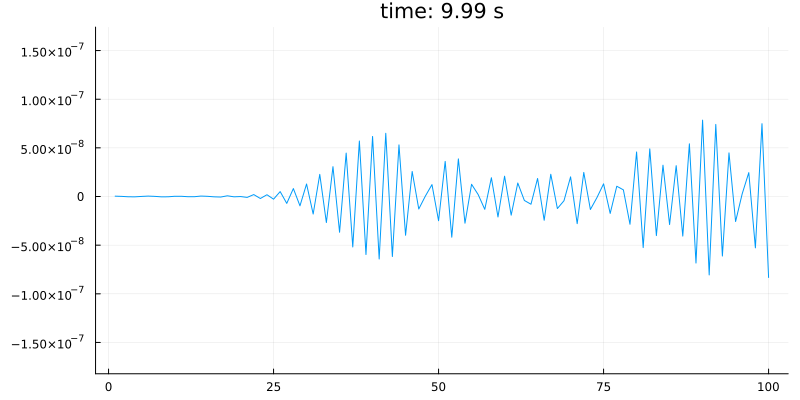

In [28]:
u_time = time_stepping(x, young_mod, ro, t_max, dt)

max_u = maximum(u_time)
min_u = minimum(u_time)

# println(u_time[nt, :])

# display
for it in 1:nt
    #     # if it % iplot == 0
    IJulia.clear_output(true)
    p = plot(u_time[it, :], legend=false, title="time: $(it*dt) s", ylims=(min_u, max_u), size=(800, 400))
    display(p)
    #     # end

    # break if u too large
    if maximum(u_time[it, :]) > 1e10
        break
    end
end